# ORIE 4580 Project Source Code

#### Mandy Gang, Brennan O'Connor, Yoanna Efimova, and Samantha Taylor

## Import and Data Prep

In [ ]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

import matplotlib.pyplot as plt 
%matplotlib inline

import random as rand
import math

from scipy import stats
import scipy

! pip install haversine
import haversine
from haversine import haversine, Unit

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# mount data file so we don't have to load it in every time
! git clone https://github.com/brennanoc43/helicopter_sim.git

Cloning into 'helicopter_sim'...
remote: Enumerating objects: 6, done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 6
Unpacking objects: 100% (6/6), done.


In [ ]:
df = pd.read_csv("/content/helicopter_sim/ProjectData.csv")
df["Lon"] = -df.Lon
df.head()

,Call ID,Time,Lat,Lon,Safe to fly,Heli avail,CancelDelay,Scene time,Hosp lat,Hosp Lon,Hosp time
0,0,0.698273,43.606190,-75.110334,1,1,0.0,0.376066,43.1009,75.2327,0.741709
1,1,0.790623,43.086142,-77.470693,1,1,0.0,0.494475,43.1566,77.6088,0.276576
2,2,3.445114,42.781114,-73.757133,1,1,0.0,0.223929,42.6526,73.7562,0.265198
3,3,3.742029,42.523381,-76.452085,1,1,0.0,0.232449,42.4440,76.5019,0.494395
4,4,6.399294,43.204620,-75.936761,1,1,0.0,0.447068,43.0481,76.1474,1.189299


## Probabilistic Call Location Generation

In [ ]:
# this function generates random locations uniformly throughout gridded regions of NYS, 
# based on the density of past calls in that region in our dataset
def generate_probabilistic_locations():
  long_min = np.min(-df.Lon)
  long_max = np.max(-df.Lon)

  lat_min = np.min(df.Lat)
  lat_max = np.max(df.Lat)

  # wanted 10mi x 10mi bins, and utitlized this information of NYS https://en.wikipedia.org/wiki/New_York_(state) to determine how many bins to create
  long_bins = np.linspace(long_min, long_max, 33)
  lat_bins = np.linspace(lat_min, lat_max, 29)

  def generateLocations(count, coord):
    for i in range(count):
      lon = np.random.uniform(coord[0][0], coord[0][1])
      lat = np.random.uniform(coord[1][0], coord[1][1])
      locations.append((lat,-lon))

  counts, xedges, yedges, im = plt.hist2d(-df.Lon, df.Lat, bins = [long_bins, lat_bins], density=True, cmap='plasma')
  
  bins = [long_bins, lat_bins]
  P = counts 
  n = 50000
  locations = []

  for c in range(1, 32):
    for r in range(1, 28):
      generateCount = int(n * P[c-1,r-1])
      #longitude, latitude
      coord = [(bins[0][c-1], bins[0][c]), (bins[1][r-1], bins[1][r])]
      
      generateLocations(generateCount, coord)

  return locations

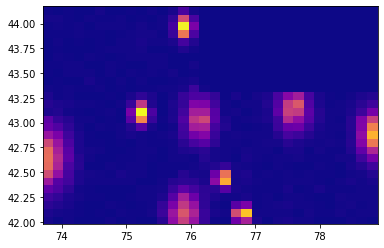

In [ ]:
global probabilistic_locations
probabilistic_locations = generate_probabilistic_locations()

## Model Logic

In [9]:
rochester = (43.1566, -77.6088)
syracuse = (43.0481, -76.1474)
albany = (42.6526, -73.7562)
sayre = (41.979, -76.5019) 
trauma_centers = [rochester, syracuse, albany, sayre]

buffalo = (42.8864, -78.8784)
elmira = (42.0898, -76.8077)
binghamton = (42.0987, -75.918)
ithaca = (42.443999999999996, -76.5155)
watertown = (43.9748, -75.9108)
utica = (43.1009, -75.2327)
hospitals = [rochester, syracuse, albany, sayre, buffalo, elmira, binghamton, ithaca, watertown, utica]

In [10]:
# this is used to make the hospitals more readable ((lat, long) -> name of city)
places = ['rochester', 'syracuse', 'albany', 'sayre', 'buffalo', 'elmira', 'binghamton', 'ithaca', 'watertown', 'utica']
place_names = {}
for i in range(len(hospitals)):
  hosp = hospitals[i]
  place_names[hosp] = places[i]

In [11]:
# get call rates table like we did in Project HW
hour_of_call = df.Time % 24

n = 365
counts = np.zeros(24)
for time in hour_of_call:
  hour = int(np.floor(time))
  counts[hour] += 1
MLEs = counts / n

call_arrival_rates = list(MLEs)
lambda_star = np.max(call_arrival_rates)

In [12]:
# generate a call according to a nonhomogeneous Poisson process with the rate 
# table determined above using thinning
def compute_time_call_received(current_time):
  n = 0  
  t_star = current_time
  while n < 1:
    candidate_interarrival_time = np.random.exponential(1 / lambda_star)

    t_star += candidate_interarrival_time

    # find lambda(t_star)
    t_star_hour = t_star % 24
    position_in_rate_list = int(t_star_hour)
    lambda_t_star = call_arrival_rates[position_in_rate_list]

    u = np.random.uniform()

    if u < lambda_t_star / lambda_star:
      n += 1
  return t_star

In [13]:
def generate_call_arrival(current_time, call_index):
  # generate random call arrival time and its location
  call_time_received = compute_time_call_received(current_time)

  random_spot = np.random.randint(0, len(probabilistic_locations))
  call_location = probabilistic_locations[random_spot]

  # store these values accordingly
  call_state[call_index] = [call_location, call_time_received, None, None]

  cancellation_inputs[call_index] = [call_time_received, None, None, None]

  return ('CallArrival', call_time_received, call_index)

In [14]:
def get_closest_available_heli(call_index):
  # return closest heli that's within 180 km range
  # get call location
  call_location = call_state.get(call_index)[0]  

  closest_heli = None
  closest_heli_distance = np.inf
  # search through helis and find closest one that is at base 
  for key, value in heli_dict.items():
    if value[0] == 'AtBase':
      distance_from_call = haversine(call_location, value[3], unit='km')
      if distance_from_call < closest_heli_distance:
        closest_heli = key
        closest_heli_distance = distance_from_call
        
  if closest_heli_distance < 180:
    base = heli_dict.get(closest_heli)[3]
    base_used[base] += 1
    return closest_heli
  else:
    return -1

In [15]:
def call_arrival(call_index):
  cancel_time = current_time + np.random.exponential(1 / .205)  

  closest_heli = get_closest_available_heli(call_index)
  if closest_heli >= 0: # if there was a heli available
    active_calls.append(call_index)

    # update heli index and cancel time
    call_info = call_state.get(call_index)    
    updated_call_info = [call_info[0], call_info[1], cancel_time, closest_heli] 
    call_state[call_index] = updated_call_info

    # update heli info
    heli_info = heli_dict.get(closest_heli)
    updated_heli_info = ['AwaitingClearance', heli_info[1], call_index, heli_info[3]] 
    heli_dict[closest_heli] = updated_heli_info

    # generate HDDispatch Time
    td = np.random.triangular(5/60, 7/60, 10/60)
    dispatch_time = current_time + td

    cancel_info = cancellation_inputs.get(call_index)
    cancellation_inputs[call_index] = [cancel_info[0], cancel_time, td, cancel_info[3]]

    if dispatch_time < cancel_time:
      event_list.append(('CallFinishesAtHD', dispatch_time, call_index))
    else:
      event_list.append(('CallCancelled', cancel_time, call_index))    

  else:
    stats['no_heli_available'] += 1
    call_state.pop(call_index, None)

  call_index += 1
  event_list.append(generate_call_arrival(current_time, call_index))

In [16]:
# this function is used to determine how much time was spent flying in the event
# of a cancellation
def determine_amount_of_time_spent_flying(call_index):
  cancel_info = cancellation_inputs.get(call_index)
  amount_of_time_flying = cancel_info[1] - (cancel_info[0] + cancel_info[2] + cancel_info[3])
  return amount_of_time_flying

In [17]:
def call_cancelled(call_index):
  h = call_state.get(call_index)[3]
  heli_info = heli_dict.get(h)
  heli_status = heli_info[0]

  if heli_status == 'AwaitingClearance' or 'PrepForCall':
    updated_heli_info = ['AtBase', heli_info[1], heli_info[2], heli_info[3]] 
    heli_dict[h] = updated_heli_info 

  if heli_status == 'OnWayToScene':
    updated_heli_info = ['OnWayToBase', heli_info[1], heli_info[2], heli_info[3]] 
    heli_dict[h] = updated_heli_info 

    # determine time of arrival at base
    base_arrival_time = current_time + determine_amount_of_time_spent_flying(call_index)

    event_list.append(('HeliArrivesAtBase', base_arrival_time, h))

  stats['calls_cancelled'] += 1

  active_calls.remove(call_index)
  call_state.pop(call_index, None)

In [18]:
def call_finishes_at_hd(call_index):
  h = call_state.get(call_index)[3]
  heli_info = heli_dict.get(h)

  probability = np.random.uniform()
  
  if probability < .101: #unsafe
    updated_heli_info = ['AtBase', heli_info[1], heli_info[2], heli_info[3]] 
    heli_dict[h] = updated_heli_info 

    stats['unsafe_to_fly'] += 1

    active_calls.remove(call_index)
    call_state.pop(call_index, None)

  else: # safe to fly
    updated_heli_info = ['PrepForCall', heli_info[1], heli_info[2], heli_info[3]] 
    heli_dict[h] = updated_heli_info 

    tp = np.random.triangular(5/60, 7.5/60, 10/60)
    prep_time = current_time + tp

    cancel_info = cancellation_inputs.get(call_index)
    cancellation_inputs[call_index] = [cancel_info[0], cancel_info[1], cancel_info[2], tp]

    call_cancelation_time = call_state.get(call_index)[2]

    if call_cancelation_time < prep_time:
      event_list.append(('CallCancelled', prep_time, call_index))
    else:
      event_list.append(('HeliDepartsForCall', prep_time, call_index))

  stats['call_gets_to_dispatch'] += 1

In [19]:
# determines how long a flight from origin -> destination will take in a heli
def determine_flight_time(origin, destination):
  distance_to_destination = haversine(origin, destination, unit='km')
  return distance_to_destination / 160

In [20]:
def heli_departs_for_call(call_index):
  h = call_state.get(call_index)[3]
  heli_info = heli_dict.get(h)

  call_location = call_state.get(call_index)[0]
  h = call_state.get(call_index)[3]
  heli_info = heli_dict.get(h)
  heli_base  = heli_info[3]

  scene_arrival_time = current_time + determine_flight_time(heli_base, call_location) # calculate based on distance

  call_cancelation_time = call_state.get(call_index)[2]

  if call_cancelation_time < scene_arrival_time:
    event_list.append(('CallCancelled', call_cancelation_time, call_index))
    # rather than storing the location the heli reaches at the time of cancellation, since the time spent flying prior 
    # to cancellation is equal to the time spent flying when a heli returns to base, this location does not matter, 
    # so we leave it like this for interpretabliity while debugging, and focus on a time based return rather than the location
    updated_heli_info = ['OnWayToScene', (-1, -1), heli_info[2], heli_info[3]] 
    heli_dict[h] = updated_heli_info 
  else:
    call_location = call_state.get(call_index)[0]

    updated_heli_info = ['OnWayToScene', call_location, heli_info[2], heli_info[3]] 
    heli_dict[h] = updated_heli_info 

    event_list.append(('HeliArrivesAtScene', scene_arrival_time, call_index))

In [21]:
def heli_arrives_at_scene(call_index):  
  stats['heli_gets_to_scene'] += 1

  stats.get('response_times').append(current_time - call_state.get(call_index)[1])

  time_spent_at_scene = np.random.gamma(2.95, .12)

  time_done_at_scene = current_time + time_spent_at_scene

  h = call_state.get(call_index)[3]
  heli_info = heli_dict.get(h)
  updated_heli_info = ['AtScene', heli_info[1], heli_info[2], heli_info[3]]
  heli_dict[h] = updated_heli_info 

  event_list.append(('HeliDepartsFromScene', time_done_at_scene, call_index))

In [22]:
# determines which of the available_facilities is closest to the given call_location
def determine_closest_facility(available_facilities, call_location):
  closest_hosp = None
  closest_hosp_distance = np.inf
  for facility in available_facilities:
    distance_to_this_hosp = haversine(call_location, facility, unit='km')
    if distance_to_this_hosp < closest_hosp_distance:
      closest_hosp = facility
      closest_hosp_distance = distance_to_this_hosp  
  return closest_hosp

In [23]:
def heli_departs_from_scene(call_index):
  toTrauma = np.random.uniform()

  call_location = call_state.get(call_index)[0]

  if toTrauma > .807: # if injury requires trauma center
    heli_destination = determine_closest_facility(trauma_centers, call_location)
    
  else:
    heli_destination = determine_closest_facility(hospitals, call_location)

  hospital_arrival_time = current_time + determine_flight_time(call_location, heli_destination) 

  h = call_state.get(call_index)[3]
  heli_info = heli_dict.get(h)

  updated_heli_info = ['OnWayToHosp', heli_destination, heli_info[2], heli_info[3]]
  heli_dict[h] = updated_heli_info 

  event_list.append(('HeliArrivesAtHosp', hospital_arrival_time, call_index))

In [24]:
def heli_arrives_at_hosp(call_index):
  stats.get('times_to_definitive_care').append(current_time - call_state.get(call_index)[1])

  h = call_state.get(call_index)[3]
  heli_info = heli_dict.get(h)

  updated_heli_info = ['AtHosp', heli_info[1], heli_info[2], heli_info[3]]
  heli_dict[h] = updated_heli_info 

  depart_hospital_time = current_time + np.random.gamma(2.91, .17)

  event_list.append(('HeliDepartsHosp', depart_hospital_time, call_index))

  day_index = int(current_time / 24 - 14)
  if day_index < 365: # fixes array errors for end of simulation behavior
    stats['daily_successful_calls'][day_index] += 1

In [25]:
def heli_departs_hosp(call_index):
  h = call_state.get(call_index)[3]
  heli_info = heli_dict.get(h)
  updated_heli_info = ['OnWayToBase', heli_info[1], heli_info[2], heli_info[3]]
  heli_dict[h] = updated_heli_info 

  heli_returns_to_base_time = current_time + determine_flight_time(heli_info[1], heli_info[3])

  event_list.append(('HeliArrivesAtBase', heli_returns_to_base_time, h))

  active_calls.remove(call_index)
  call_state.pop(call_index, None)

In [26]:
def heli_arrives_at_base(h):
  heli_info = heli_dict.get(h)
  updated_heli_info = ['AtBase', heli_info[1], heli_info[2], heli_info[3]]
  heli_dict[h] = updated_heli_info 

In [27]:
# this is used to initiate a given event based on our event list
def initiate_event(event_to_initiate, call_or_heli_index):
  if event_to_initiate == 'CallArrival':
    call_arrival(call_or_heli_index)
  elif event_to_initiate == 'CallCancelled':
    call_cancelled(call_or_heli_index)
  elif event_to_initiate == 'CallFinishesAtHD':
    call_finishes_at_hd(call_or_heli_index)
  elif event_to_initiate == 'HeliDepartsForCall':
    heli_departs_for_call(call_or_heli_index)
  elif event_to_initiate == 'HeliArrivesAtScene':
    heli_arrives_at_scene(call_or_heli_index)
  elif event_to_initiate == 'HeliDepartsFromScene':
    heli_departs_from_scene(call_or_heli_index)
  elif event_to_initiate == 'HeliArrivesAtHosp':
    heli_arrives_at_hosp(call_or_heli_index)
  elif event_to_initiate == 'HeliDepartsHosp':
    heli_departs_hosp(call_or_heli_index)
  elif event_to_initiate == 'HeliArrivesAtBase':
    heli_arrives_at_base(call_or_heli_index)

## Batch Means Simulation

In [28]:
# this modifies the stats we had been keeping into the key metrics for our decision making
def convert_stats(stats, current_call_index):
  final_stats = dict([(key, round(np.mean(value), 3)) for key, value in stats.items()])  
  num_calls_received = current_call_index - final_stats.get('last_warmup_call')
  final_stats['percentage_of_calls_dispatched'] = round((num_calls_received - (final_stats.get('unsafe_to_fly') + final_stats.get('no_heli_available'))) / num_calls_received, 3)
  final_stats['response_fraction'] = round(final_stats.get('heli_gets_to_scene') / final_stats.get('call_gets_to_dispatch'), 3)
  final_stats['utilization'] = round(np.mean(stats.get('daily_successful_calls')) / num_helis, 3)
  return final_stats

In [31]:
def simulate_batches(heli_bases, current_results):
  # these will hold each stat for each of our batches
  replicated_stats = {}
  replicated_stats['response_times'] = []
  replicated_stats['response_fraction'] = []
  replicated_stats['utilization'] = []
  replicated_stats['no_heli_available'] = []
  replicated_stats['times_to_definitive_care'] = []
  replicated_stats['percentage_of_calls_dispatched'] = []

  warmup_period = 24*14

  years = 1

  run_length = 24*365*years

  batch = 1
  num_batches = 20
  batch_length = run_length / num_batches

  # these will keep track of various stats throughout our simulation
  # note: global variables were used in many cases so that they could be accessed
  # by other functions throughout the simulation
  global stats
  stats = {}
  stats['no_heli_available'] = 0
  stats['calls_cancelled'] = 0
  stats['unsafe_to_fly'] = 0
  stats['heli_gets_to_scene'] = 0
  stats['call_gets_to_dispatch'] = 0
  stats['daily_successful_calls'] = 365*years*[0]
  stats['last_warmup_call'] = 0
  stats['times_to_definitive_care'] = []
  stats['response_times'] = []

  # sim initialization
  global active_calls
  active_calls = []
  call_index = 0
  global current_time
  current_time = 0

  # initialize call states
  global call_state
  # Call Location, Time Received, Cancel Time, Heli Index
  call_state = {}

  # time recieved, cancel time, dispatch time, prep time
  global cancellation_inputs
  cancellation_inputs = {}

  global num_helis
  num_helis = 12 - heli_bases.count(None)

  # use to see which hospitals get the largest fraction of calls
  # infinite_helis = []
  # for hosp in hospitals:
  #   infinite_helis += 100*[hosp]
  # heli_bases = infinite_helis

  # determine which bases are best in the unlimited case above
  # global base_used
  # base_used = {}
  # for base in hospitals:
  #   base_used[base] = 0

  # initialize helicopter states
  global heli_dict
  heli_dict = {}
  for i in range(num_helis):
    # Status, Destination, Index of Call, Base
    heli_dict[i] = ['AtBase', (None,None), None, heli_bases[i]]  

  global current_call_index
  current_call_index = None

  # begin simulation with a call arrival
  global event_list
  event_list = [generate_call_arrival(current_time, call_index)]
  while(current_time < warmup_period + run_length):
    # don't count stats until after warmup period
    if current_time < warmup_period:
      stats['no_heli_available'] = 0
      stats['calls_cancelled'] = 0
      stats['unsafe_to_fly'] = 0
      stats['heli_gets_to_scene'] = 0
      stats['call_gets_to_dispatch'] = 0
      stats['daily_successful_calls'] = 365*[0]
      stats['last_warmup_call'] = current_call_index
      stats['times_to_definitive_care'] = []
      stats['response_times'] = []

    # determine next event
    event_list.sort(key = lambda x: x[1], reverse=False)
    next_event = event_list.pop(0)
    current_time = next_event[1]

    # do next event
    event_to_initiate = next_event[0]

    # since the associated call index gets deleted prior to this function, 
    # we have to differentiate between the call and heli index
    if event_to_initiate == 'HeliArrivesAtBase':
      heli_index = next_event[2]
      initiate_event(event_to_initiate, heli_index)
    else:
      current_call_index = next_event[2]
      initiate_event(event_to_initiate, current_call_index)      

    # if we have reached the end of the previous batch
    if current_time > warmup_period + batch*batch_length:
      # if we haven't done too many batches
      if batch <= num_batches:
        # append batch stats
        final_stats = convert_stats(stats, current_call_index)
      
        for key, value in final_stats.items():
          if key in replicated_stats.keys():
            replicated_stats[key].append(value)

        batch += 1

        # reset stats for the upcoming batch
        stats['no_heli_available'] = 0
        stats['calls_cancelled'] = 0
        stats['unsafe_to_fly'] = 0
        stats['heli_gets_to_scene'] = 0
        stats['call_gets_to_dispatch'] = 0
        stats['daily_successful_calls'] = 365*[0]
        stats['last_warmup_call'] = current_call_index
        stats['times_to_definitive_care'] = []
        stats['response_times'] = []  

  # return this after the simulation has been completed, the result will be a 
  # dataframe will all statistics and metrics of interest
  readable_bases = []
  for base in heli_bases:
    if base is not None:
      readable_bases.append(place_names.get(base))

  multiplier = 2.09 / np.sqrt(num_batches) # 2.26 (10 batches) or 2.09 (20)
  numeric_results = [[readable_bases, 60*np.mean(replicated_stats.get('response_times')), np.mean(replicated_stats.get('response_fraction')), num_batches*np.mean(replicated_stats.get('utilization')), 60*np.mean(replicated_stats.get('times_to_definitive_care')), num_batches/(365*years)*np.mean(replicated_stats.get('no_heli_available')), np.mean(replicated_stats.get('percentage_of_calls_dispatched')), multiplier*np.std(replicated_stats.get('response_times')), multiplier*np.std(replicated_stats.get('response_fraction')), multiplier*np.std(replicated_stats.get('utilization')), multiplier*np.std(replicated_stats.get('percentage_of_calls_dispatched')), multiplier*np.std(replicated_stats.get('times_to_definitive_care'))]]
  results_to_add = pd.DataFrame(numeric_results, columns=["Heli Locations", "Average Response Time", "Response Fraction", "Utilization", "Time to Definitive Care", "Daily No Helis Available", "% Dispatched", "Average Response Time HW", "Response Fraction HW", "Utilization HW", "% Dispatched HW", "TDC HW"])
  return current_results.append(results_to_add, ignore_index=True)

In [51]:
current_results = pd.DataFrame(columns=["Heli Locations", "Average Response Time", "Response Fraction", "Utilization", "Time to Definitive Care", "Daily No Helis Available", "% Dispatched", "Average Response Time HW", "Response Fraction HW", "Utilization HW"])
possible_arrangements = [[rochester, rochester, rochester, albany, albany, albany, syracuse, syracuse,syracuse, watertown, ithaca, utica],                       
                        [rochester, rochester, rochester, albany, albany, syracuse, syracuse, watertown, ithaca, elmira, binghampton, utica],
                        [rochester, rochester, albany, albany, albany, syracuse, syracuse, watertown, ithaca, sayre, elmira, utica],
                        [rochester, rochester, albany, albany, syracuse, syracuse, watertown, watertown, ithaca, elmira, binghampton, utica]]

# simulate all possible arrangements of helis and output the resulting sorted dataframe
for trial in range(len(possible_arrangements)):
  print(trial)
  current_results = simulate_batches([possible_arrangements[trial][0], possible_arrangements[trial][1], possible_arrangements[trial][2], possible_arrangements[trial][3], possible_arrangements[trial][4], possible_arrangements[trial][5], possible_arrangements[trial][6], possible_arrangements[trial][7], possible_arrangements[trial][8], possible_arrangements[trial][9], possible_arrangements[trial][10], possible_arrangements[trial][11]], current_results)
current_results.insert(6, "Total No Helis Available", current_results['Daily No Helis Available'] * 365)
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

0
1
2
3


,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
1,"[rochester, rochester, rochester, albany, alba...",28.662,0.83495,3.006,59.304,0.778082,284.0,0.88480,0.005285,0.006729,0.012317,0.004628,0.008476
2,"[rochester, rochester, albany, albany, albany,...",29.673,0.83550,2.991,60.189,0.863014,315.0,0.88910,0.006734,0.004267,0.012079,0.004208,0.008858
0,"[rochester, rochester, rochester, albany, alba...",31.986,0.82745,2.939,62.466,0.928767,339.0,0.88445,0.004731,0.005705,0.012098,0.005791,0.007463
3,"[rochester, rochester, albany, albany, syracus...",28.479,0.83840,2.956,59.109,0.950685,347.0,0.88695,0.005809,0.005570,0.012438,0.004611,0.007239


## Unlimited Bases Simulation Results

Approximated fraction of flights that get routed through a certain base by treating the scenario as having an infinite number of helicopters. This is far from a final estimate, but serves as a good initialization point for the model that can be tweaked. The fractions are as follows 

*   'albany': 0.196,
*   'binghampton': 0.117
*   'buffalo': 0.134,
*   'elmira': 0.06,
*   'ithaca': 0.06,
*   'rochester': 0.131,
*   'sayre': 0.002,
*    'syracuse': 0.129,
*   'utica': 0.09,
*   'watertown': 0.081

In the initial model, this equates to placing roughly 
*   2 in 'albany'
*   1 in 'binghampton'
*   1 in 'buffalo'
*   1 in 'elmira'
*   1 in 'ithaca'
*   2 in 'rochester'
*   0 in 'sayre'
*   2 in  'syracuse'
*   1 in 'utica'
*   1 in 'watertown

In [ ]:
pd.set_option("display.max_columns", None)
print('With one helicopter\n')
current_results.insert(6, "Total No Helis Available", current_results['Daily No Helis Available'] * 365)
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With one helicopter



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
1,[ithaca],48.105,0.77395,5.864,78.006,37.720548,13768.0,0.15865,0.011487,0.016377,0.024656,0.003894,0.014657
2,[syracuse],48.357,0.78050,6.077,78.474,38.397260,14015.0,0.16040,0.008732,0.015920,0.025412,0.004010,0.016858
0,[albany],41.940,0.80255,4.951,73.851,39.808219,14530.0,0.12825,0.015319,0.014395,0.021449,0.003110,0.021748


In [ ]:
pd.set_option("display.max_columns", None)
print('With two helicopters\n')
current_results.insert(6, "Total No Helis Available", current_results['Daily No Helis Available'] * 365)
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With two helicopters



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
1,"[utica, elmira]",51.636,0.7674,5.344,81.873,32.230137,11764.0,0.28300,0.010414,0.012516,0.022642,0.004560,0.015756
0,"[rochester, albany]",47.433,0.7850,5.143,78.552,32.350685,11808.0,0.27355,0.011196,0.014257,0.021654,0.004249,0.013669


In [ ]:
pd.set_option("display.max_columns", None)
print('With three helicopters\n')
current_results.insert(6, "Total No Helis Available", current_results['Daily No Helis Available'] * 365)
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With three helicopters



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
0,"[rochester, albany, syracuse]",44.262,0.7881,5.162,75.147,25.657534,9365.0,0.4049,0.007619,0.010231,0.021635,0.006164,0.00935


In [ ]:
pd.set_option("display.max_columns", None)
print('With four helicopters\n')
current_results.insert(6, "Total No Helis Available", current_results['Daily No Helis Available'] * 365)
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With four helicopters



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
0,"[rochester, albany, syracuse, syracuse]",42.753,0.7969,4.955,73.116,20.276712,7401.0,0.5114,0.00602,0.009758,0.020402,0.008067,0.010186


In [ ]:
pd.set_option("display.max_columns", None)
print('With five helicopters\n')
current_results.insert(6, "Total No Helis Available", current_results['Daily No Helis Available'] * 365)
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With five helicopters



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
0,"[rochester, albany, syracuse, syracuse, ithaca]",40.056,0.8004,4.678,70.428,14.967123,5463.0,0.60815,0.005832,0.007286,0.019103,0.006014,0.009031


In [ ]:
pd.set_option("display.max_columns", None)
print('With six helicopters\n')
current_results.insert(6, "Total No Helis Available", current_results['Daily No Helis Available'] * 365)
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With six helicopters



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
0,"[rochester, albany, syracuse, watertown, ithac...",38.85,0.8026,4.399,69.381,11.589041,4230.0,0.67725,0.007277,0.00697,0.0175,0.008637,0.009505


^^ [rochester, albany, syracuse, watertown, ithaca, utica]

In [ ]:
pd.set_option("display.max_columns", None)
print('With seven helicopters\n')
current_results.insert(6, "Total No Helis Available", current_results['Daily No Helis Available'] * 365)
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With seven helicopters



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
0,"[rochester, albany, syracuse, watertown, ithac...",36.456,0.8125,4.178,66.843,8.024658,2929.0,0.74635,0.008291,0.007724,0.017553,0.011101,0.009584


[rochester, albany, syracuse, watertown, ithaca, binghampton, utica]

In [ ]:
pd.set_option("display.max_columns", None)
print('With eight helicopters\n')
current_results.insert(6, "Total No Helis Available", current_results['Daily No Helis Available'] * 365)
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With eight helicopters



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
0,"[rochester, albany, syracuse, syracuse, watert...",34.836,0.81425,3.895,65.202,5.813699,2122.0,0.78995,0.00682,0.006728,0.015607,0.00705,0.009811


[rochester, albany, syracuse, syracuse, watertown, ithaca, binghampton, utica]

In [ ]:
pd.set_option("display.max_columns", None)
print('With nine helicopters\n')
current_results.insert(6, "Total No Helis Available", current_results['Daily No Helis Available'] * 365)
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With nine helicopters



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
0,"[rochester, rochester, albany, syracuse, syrac...",33.276,0.82205,3.633,63.873,3.657534,1335.0,0.82965,0.005507,0.005209,0.014797,0.005234,0.007068


[rochester, rochester, albany, syracuse, syracuse, watertown, ithaca, binghampton, utica]

In [ ]:
pd.set_option("display.max_columns", None)
print('With ten helicopters\n')
current_results.insert(6, "Total No Helis Available", current_results['Daily No Helis Available'] * 365)
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With ten helicopters



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
0,"[rochester, rochester, albany, albany, syracus...",32.115,0.8258,3.474,62.817,2.389041,872.0,0.85405,0.005324,0.004829,0.014273,0.005591,0.006672


[rochester, rochester, albany, albany, syracuse, syracuse, watertown, ithaca, sayre, utica]

In [ ]:
pd.set_option("display.max_columns", None)
print('With eleven helicopters\n')
current_results.insert(6, "Total No Helis Available", current_results['Daily No Helis Available'] * 365)
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With eleven helicopters



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
0,"[rochester, rochester, albany, albany, syracus...",29.325,0.8334,3.218,60.057,1.317808,481.0,0.8745,0.005373,0.005842,0.013513,0.005686,0.007555


[rochester, rochester, albany, albany, syracuse, syracuse, watertown, ithaca, elmira, binghampton, utica]

In [53]:
pd.set_option("display.max_columns", None)
print('With twelve helicopters\n')
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With twelve helicopters



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
1,"[rochester, rochester, rochester, albany, alba...",28.662,0.83495,3.006,59.304,0.778082,284.0,0.88480,0.005285,0.006729,0.012317,0.004628,0.008476
2,"[rochester, rochester, albany, albany, albany,...",29.673,0.83550,2.991,60.189,0.863014,315.0,0.88910,0.006734,0.004267,0.012079,0.004208,0.008858
0,"[rochester, rochester, rochester, albany, alba...",31.986,0.82745,2.939,62.466,0.928767,339.0,0.88445,0.004731,0.005705,0.012098,0.005791,0.007463
3,"[rochester, rochester, albany, albany, syracus...",28.479,0.83840,2.956,59.109,0.950685,347.0,0.88695,0.005809,0.005570,0.012438,0.004611,0.007239


rochester, rochester, rochester, albany, albany, syracuse, syracuse, watertown, ithaca, elmira, binghampton, utica aka 1

## Subset Simulation Results

In [ ]:
pd.set_option("display.max_columns", None)
print('With one helicopter\n')
current_results.insert(6, "Total No Helis Available", current_results['Daily No Helis Available'] * 365)
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With one helicopter



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
1,[ithaca],48.105,0.77395,5.864,78.006,37.720548,13768.0,0.15865,0.011487,0.016377,0.024656,0.003894,0.014657
2,[syracuse],48.357,0.78050,6.077,78.474,38.397260,14015.0,0.16040,0.008732,0.015920,0.025412,0.004010,0.016858
0,[albany],41.940,0.80255,4.951,73.851,39.808219,14530.0,0.12825,0.015319,0.014395,0.021449,0.003110,0.021748


In [ ]:
pd.set_option("display.max_columns", None)
print('With two helicopters\n')
current_results.insert(6, "Total No Helis Available", current_results['Daily No Helis Available'] * 365)
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With two helicopters



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
1,"[utica, elmira]",51.636,0.7674,5.344,81.873,32.230137,11764.0,0.28300,0.010414,0.012516,0.022642,0.004560,0.015756
0,"[rochester, albany]",47.433,0.7850,5.143,78.552,32.350685,11808.0,0.27355,0.011196,0.014257,0.021654,0.004249,0.013669


In [ ]:
pd.set_option("display.max_columns", None)
print('With three helicopters\n')
current_results.insert(6, "Total No Helis Available", current_results['Daily No Helis Available'] * 365)
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With three helicopters



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
0,"[rochester, albany, syracuse]",44.262,0.7881,5.162,75.147,25.657534,9365.0,0.4049,0.007619,0.010231,0.021635,0.006164,0.00935


In [ ]:
pd.set_option("display.max_columns", None)
print('With four helicopters\n')
current_results.insert(6, "Total No Helis Available", current_results['Daily No Helis Available'] * 365)
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With four helicopters



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
0,"[rochester, albany, syracuse, syracuse]",42.753,0.7969,4.955,73.116,20.276712,7401.0,0.5114,0.00602,0.009758,0.020402,0.008067,0.010186


In [ ]:
pd.set_option("display.max_columns", None)
print('With five helicopters\n')
current_results.insert(6, "Total No Helis Available", current_results['Daily No Helis Available'] * 365)
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With five helicopters



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
0,"[rochester, albany, syracuse, syracuse, ithaca]",40.056,0.8004,4.678,70.428,14.967123,5463.0,0.60815,0.005832,0.007286,0.019103,0.006014,0.009031


Approximated fraction of flights that get routed through a certain base by treating the scenario as having an infinite number of helicopters. This is far from a final estimate, but serves as a good initialization point for the model that can be tweaked. The fractions are as follows 

*   'albany': 0.196,
*   'binghampton': 0.117
*   'buffalo': 0.134,
*   'elmira': 0.06,
*   'ithaca': 0.06,
*   'rochester': 0.131,
*   'sayre': 0.002,
*    'syracuse': 0.129,
*   'utica': 0.09,
*   'watertown': 0.081

In the initial model, this equates to placing roughly 
*   2 in 'albany'
*   1 in 'binghampton'
*   1 in 'buffalo'
*   1 in 'elmira'
*   1 in 'ithaca'
*   2 in 'rochester'
*   0 in 'sayre'
*   2 in  'syracuse'
*   1 in 'utica'
*   1 in 'watertown

In [37]:
pd.set_option("display.max_columns", None)
print('With six helicopters\n')
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With six helicopters



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
2,"[rochester, rochester, albany, syracuse, syrac...",39.573,0.80750,4.378,70.044,11.427397,4171.0,0.68070,0.005501,0.004960,0.017545,0.007447,0.007759
0,"[rochester, rochester, albany, syracuse, water...",39.120,0.80620,4.304,69.699,11.975342,4371.0,0.66760,0.005988,0.005590,0.017573,0.008482,0.009630
3,"[rochester, rochester, albany, syracuse, syrac...",41.901,0.79770,4.320,72.570,12.293151,4487.0,0.66325,0.007429,0.007106,0.017585,0.006086,0.008694
1,"[rochester, albany, syracuse, syracuse, watert...",38.919,0.81055,4.351,69.357,12.394521,4524.0,0.66425,0.005929,0.008513,0.017730,0.007579,0.007664
4,"[rochester, rochester, rochester, albany, syra...",42.738,0.79775,4.219,73.227,12.915068,4714.0,0.65305,0.004846,0.007796,0.017891,0.006253,0.007766


^^ [rochester, rochester, albany, syracuse, syracuse, ithaca]

In [39]:
pd.set_option("display.max_columns", None)
print('With seven helicopters\n')
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With seven helicopters



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
3,"[rochester, rochester, albany, syracuse, syrac...",38.412,0.8119,4.172,68.922,8.380822,3059.0,0.74215,0.007442,0.008093,0.017287,0.006729,0.008532
4,"[rochester, rochester, albany, syracuse, syrac...",41.151,0.7997,4.079,71.691,8.539726,3117.0,0.73635,0.008009,0.008179,0.016940,0.007607,0.009224
0,"[rochester, rochester, albany, syracuse, syrac...",37.230,0.8121,4.074,67.752,8.767123,3200.0,0.73165,0.006055,0.006551,0.016439,0.006427,0.009137
2,"[rochester, rochester, albany, syracuse, syrac...",37.851,0.8104,4.050,68.445,8.791781,3209.0,0.73135,0.006031,0.006718,0.016557,0.009969,0.006890
1,"[rochester, rochester, albany, syracuse, water...",37.071,0.8076,4.079,67.536,9.030137,3296.0,0.72435,0.008614,0.006656,0.016854,0.007681,0.010121


rochester, rochester, albany, syracuse, syracuse, ithaca, utica

In [41]:
pd.set_option("display.max_columns", None)
print('With eight helicopters\n')
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With eight helicopters



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
4,"[rochester, rochester, albany, syracuse, syrac...",37.632,0.81315,3.964,67.974,5.517808,2014.0,0.79910,0.005821,0.005366,0.016230,0.007126,0.007842
3,"[rochester, rochester, albany, syracuse, syrac...",36.450,0.81360,3.918,66.945,5.586301,2039.0,0.79135,0.004808,0.005394,0.016169,0.005743,0.007949
2,"[rochester, rochester, albany, albany, syracus...",36.945,0.81885,3.915,67.647,5.821918,2125.0,0.79185,0.006993,0.008011,0.015658,0.007148,0.006783
0,"[rochester, rochester, albany, albany, syracus...",36.162,0.81365,3.867,66.672,5.961644,2176.0,0.78665,0.005273,0.005651,0.015784,0.006122,0.008183
7,"[rochester, rochester, albany, albany, syracus...",38.046,0.80965,3.804,68.607,6.054795,2210.0,0.78190,0.007049,0.005998,0.015902,0.006180,0.009181
5,"[rochester, rochester, albany, syracuse, syrac...",39.240,0.80815,3.843,69.816,6.238356,2277.0,0.78460,0.006095,0.007387,0.015714,0.007828,0.009803
6,"[rochester, rochester, albany, syracuse, syrac...",34.923,0.81940,3.817,65.700,6.421918,2344.0,0.78035,0.006444,0.006525,0.016274,0.006894,0.006857
1,"[rochester, rochester, albany, albany, syracus...",39.384,0.80580,3.713,70.305,7.178082,2620.0,0.76385,0.005337,0.006210,0.015356,0.006606,0.007250


rochester, rochester, albany, syracuse, syracuse, ithaca, ithaca, utica

In [43]:
pd.set_option("display.max_columns", None)
print('With nine helicopters\n')
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With nine helicopters



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
0,"[rochester, rochester, albany, albany, syracus...",34.647,0.81915,3.704,65.124,3.397260,1240.0,0.83780,0.004677,0.007770,0.014814,0.007650,0.005908
2,"[rochester, rochester, albany, syracuse, syrac...",35.229,0.81240,3.576,65.880,3.808219,1390.0,0.82425,0.003754,0.004882,0.014365,0.007307,0.005722
1,"[rochester, rochester, albany, syracuse, syrac...",35.847,0.81355,3.627,66.324,3.865753,1411.0,0.82695,0.006687,0.006304,0.014696,0.005253,0.008868
4,"[rochester, rochester, albany, syracuse, syrac...",35.340,0.81280,3.577,65.910,3.887671,1419.0,0.82425,0.004848,0.005222,0.014805,0.007451,0.006155
3,"[rochester, rochester, rochester, albany, syra...",35.772,0.81450,3.575,66.267,4.389041,1602.0,0.81635,0.007039,0.006342,0.014563,0.004957,0.009891


rochester, rochester, albany, albany, syracuse, syracuse, ithaca, ithaca, utica

In [45]:
pd.set_option("display.max_columns", None)
print('With ten helicopters\n')
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With ten helicopters



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
9,"[rochester, rochester, albany, albany, syracus...",33.990,0.82010,3.407,64.578,2.043836,746.0,0.86330,0.005385,0.005402,0.014297,0.005546,0.006774
6,"[rochester, rochester, albany, albany, syracus...",33.624,0.82120,3.417,64.323,2.172603,793.0,0.85680,0.006185,0.005024,0.014072,0.005685,0.008878
1,"[rochester, rochester, rochester, albany, alba...",34.302,0.82345,3.427,64.761,2.331507,851.0,0.85890,0.006307,0.007408,0.013800,0.008352,0.008429
8,"[rochester, rochester, albany, albany, syracus...",33.525,0.82135,3.389,64.224,2.380822,869.0,0.85445,0.005870,0.006466,0.014352,0.006356,0.006626
0,"[rochester, rochester, rochester, albany, alba...",35.250,0.81630,3.418,65.811,2.446575,893.0,0.85435,0.005519,0.006195,0.014210,0.005665,0.008601
7,"[rochester, rochester, albany, albany, albany,...",34.221,0.82250,3.390,64.725,2.526027,922.0,0.85350,0.006343,0.007598,0.013526,0.007051,0.008335
2,"[rochester, rochester, rochester, albany, syra...",34.545,0.81400,3.292,65.073,2.950685,1077.0,0.84155,0.004968,0.006903,0.013956,0.006439,0.007643
4,"[rochester, rochester, rochester, rochester, a...",36.792,0.80825,3.307,67.449,3.235616,1181.0,0.83725,0.005041,0.006741,0.013230,0.006028,0.006250
3,"[rochester, rochester, rochester, rochester, a...",36.726,0.80615,3.230,67.158,4.649315,1697.0,0.81020,0.005320,0.006479,0.012983,0.004826,0.006603
5,"[rochester, rochester, rochester, rochester, a...",35.757,0.81515,3.191,66.165,4.706849,1718.0,0.81115,0.004847,0.006441,0.012815,0.006666,0.007371


rochester, rochester, albany, albany, syracuse, syracuse, ithaca, ithaca, utica, utica

In [47]:
pd.set_option("display.max_columns", None)
print('With eleven helicopters\n')
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With eleven helicopters



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
3,"[rochester, rochester, albany, albany, syracus...",33.057,0.8301,3.171,63.471,1.194521,436.0,0.88100,0.005026,0.005007,0.013209,0.004952,0.005912
1,"[rochester, rochester, rochester, albany, alba...",32.985,0.8187,3.135,63.600,1.208219,441.0,0.87705,0.005773,0.006045,0.013121,0.005069,0.008851
4,"[rochester, rochester, albany, albany, syracus...",32.472,0.8252,3.187,63.051,1.232877,450.0,0.87820,0.005399,0.004714,0.013522,0.005182,0.007190
2,"[rochester, rochester, albany, albany, albany,...",32.913,0.8199,3.148,63.483,1.290411,471.0,0.87510,0.003981,0.005514,0.012911,0.004734,0.006597
5,"[rochester, rochester, albany, albany, syracus...",33.561,0.8168,3.169,63.972,1.295890,473.0,0.87265,0.005457,0.007039,0.013499,0.005135,0.008310
0,"[rochester, rochester, rochester, albany, alba...",33.042,0.8208,3.165,63.732,1.498630,547.0,0.86945,0.005115,0.006044,0.012871,0.004498,0.008938


rochester, rochester, albany, albany, syracuse, syracuse, ithaca, ithaca, ithaca, utica, utica

In [49]:
pd.set_option("display.max_columns", None)
print('With twelve helicopters\n')
current_results.sort_values(by=['Daily No Helis Available', 'Average Response Time', 'Utilization'])

With twelve helicopters



,Heli Locations,Average Response Time,Response Fraction,Utilization,Time to Definitive Care,Daily No Helis Available,Total No Helis Available,% Dispatched,Average Response Time HW,Response Fraction HW,Utilization HW,% Dispatched HW,TDC HW
3,"[rochester, rochester, rochester, albany, alba...",32.043,0.82420,2.927,62.781,0.660274,241.0,0.88730,0.004277,0.007386,0.012054,0.004919,0.006848
1,"[rochester, rochester, rochester, albany, alba...",32.469,0.82825,2.964,63.027,0.753425,275.0,0.88825,0.006400,0.003870,0.012456,0.004185,0.007865
2,"[rochester, rochester, rochester, albany, alba...",32.067,0.82305,2.918,62.613,0.769863,281.0,0.88440,0.005866,0.007177,0.012498,0.004515,0.009463
7,"[rochester, rochester, albany, albany, syracus...",32.436,0.82015,2.929,62.964,0.783562,286.0,0.88310,0.005726,0.006144,0.012138,0.004494,0.008955
0,"[rochester, rochester, rochester, albany, alba...",32.547,0.82910,2.978,63.099,0.797260,291.0,0.88985,0.004166,0.004706,0.012335,0.004395,0.006995
4,"[rochester, rochester, albany, albany, syracus...",31.812,0.82945,3.010,62.223,0.857534,313.0,0.88895,0.004756,0.005336,0.012543,0.004817,0.007876
5,"[rochester, rochester, albany, albany, albany,...",32.142,0.82550,2.971,62.745,0.876712,320.0,0.88370,0.005240,0.005997,0.012245,0.005236,0.007722
8,"[rochester, rochester, rochester, rochester, a...",32.883,0.82280,2.923,63.261,0.936986,342.0,0.88040,0.003545,0.005379,0.012314,0.005471,0.006269
6,"[rochester, rochester, albany, albany, syracus...",32.292,0.82750,2.942,62.928,0.983562,359.0,0.88135,0.004264,0.005501,0.011829,0.004558,0.007571


rochester, rochester, rochester, albany, albany, syracuse, syracuse, syracuse, ithaca, ithaca, utica, utica